# Detectando Eventos Antisacádicos

## Configuración del ambiente

In [3]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [14, 8]

## Carga del Estudio y la Prueba

In [4]:
from bsp.core import load_study

study = load_study("data/20240420-rbg-antisaccade.bsp")

antisaccadic = study[1]

# Vamos a operar esta vez con la señal cruda para utilizar toda la información
# posible y controlar mejor el efecto de los algoritmos
hori_channel = antisaccadic.hor_channel_raw
stim_channel = antisaccadic.hor_stimuli_raw

## Funciones y Clases Utilitarias

In [5]:
import numpy as np
from scipy import signal
from enum import Enum
from bsp.core.differentiation import differentiate
from typing import Iterator

class Direction(Enum):
    Same = "same"
    Left = "left"
    Right = "right"


class Size(Enum):
    Invalid = "inv"
    Small = "small"
    Large = "large"


def scale_channel(value: np.ndarray, angle: float) -> np.ndarray:
    # Llevar el estímulo al angulo indicado
    min_value = min(value)
    max_value = max(value)

    amplitude_raw = max_value - min_value
    scale = angle / amplitude_raw
    print("scale_channel: ", scale)
    return value * scale

def center_signal(value: np.ndarray) -> np.ndarray:
    return value - value.mean()

def denoise_35(channel: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.035)
    y = signal.filtfilt(b, a, channel)
    return y

def impulses(
    channel: np.ndarray, 
    peaks: list[int], 
    velocity_threshold: float = 10.0,  # Grados por segundo
    duration_threshold: float = 10     # Milisegundos o muestras
) -> Iterator[tuple[int, int]]:
    for peak in peaks:
        onset = peak
        while onset > 0 and channel[onset - 1] >= velocity_threshold:
            onset -= 1
            
        offset = peak
        while offset < len(channel) - 1 and channel[offset + 1] >= velocity_threshold:
            offset += 1

        if offset - onset >= duration_threshold:
            yield onset, offset


def clasify_impulses(
    channel: np.ndarray, 
    impulses: tuple[int, int]
) -> Iterator[tuple[int, int, Direction, Size, int, float]]:
    # Onset, Offset, Direction, Size, Duration, Amplitude
    already_yielded = set()
    
    for onset, offset in impulses:
        duration = offset - onset
        
        onset_angle = channel[onset]
        offset_angle = channel[offset]

        amplitude = abs(offset_angle - onset_angle)
        if onset_angle < offset_angle:
            direction = Direction.Right
        elif onset_angle > offset_angle:
            direction = Direction.Left
        else:
            direction = Direction.Same

        if amplitude < 1.0:
            size = Size.Invalid
        elif amplitude < 5.0:
            size = Size.Small
        else:
            size = Size.Large

        if (onset, offset) not in already_yielded:
            already_yielded.add((onset, offset))
        else:
            continue

        yield onset, offset, direction, size, duration, amplitude

## Procedimiento

scale_channel:  0.03484320557491289
scale_channel:  0.00075
#01 - 62 86 Right Invalid 24 0.5259083753330063
#02 - 241 262 Right Invalid 21 0.4208864763268554
#03 - 2041 2116 Left Large 75 5.702292968098161
#04 - 3584 3702 Right Large 118 16.796243189505358
#05 - 4066 4109 Left Small 43 1.4078600933146381
#06 - 4179 4227 Left Small 48 1.010164737656578
#07 - 5334 5437 Left Large 103 11.99845681627059
#08 - 7081 7122 Left Small 41 1.1021842844173884
#09 - 7222 7340 Right Large 118 14.92956260756793
#10 - 9050 9159 Left Large 109 13.256897459754164
#11 - 10634 10653 Left Invalid 19 0.35214490245290797
#12 - 10726 10842 Right Large 116 14.464055498978704
#13 - 12538 12650 Left Large 112 15.551526835615249
#14 - 12929 12950 Right Invalid 21 0.33984789274848826
#15 - 14257 14364 Right Large 107 13.028520303596585
#16 - 14694 14748 Right Small 54 2.4559500575464277
#17 - 16064 16207 Left Large 143 14.728330047723277
#18 - 16363 16403 Left Small 40 1.4638839542780442
#19 - 17765 17889 Right La

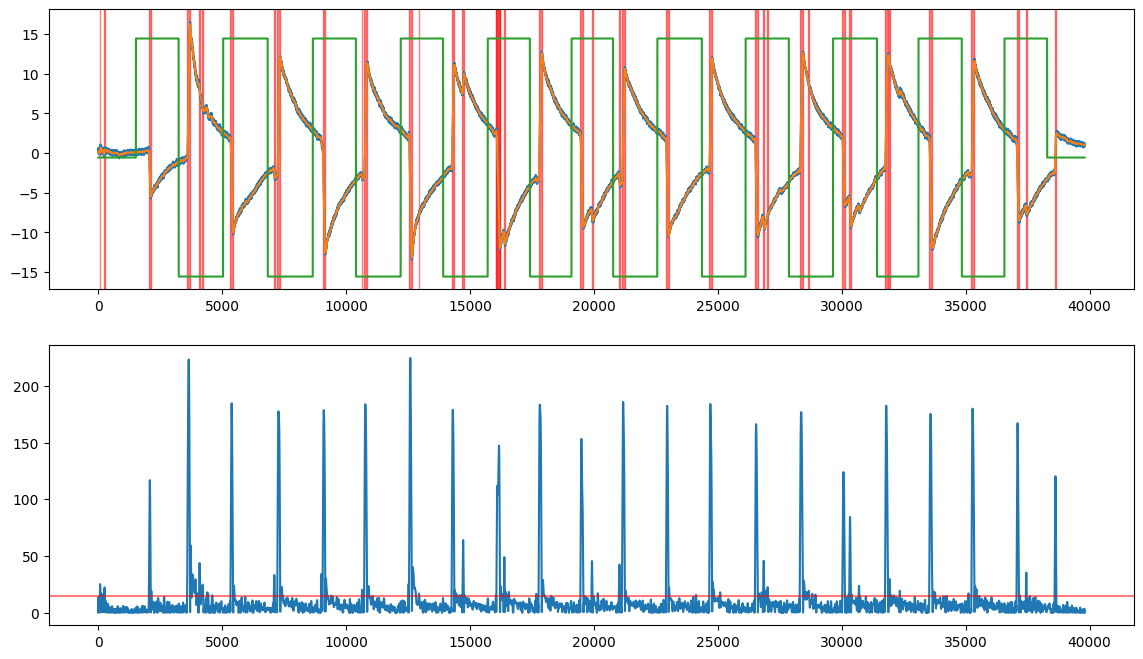

In [6]:
# Antes que nada vamos a quitar las primeras y las últimas muestras
# Con esto evitamos problemas con el escalado
SAMPLES_TO_CUT = 100
cutted_hori_channel = hori_channel[SAMPLES_TO_CUT:-SAMPLES_TO_CUT]
cutted_stim_channel = stim_channel[SAMPLES_TO_CUT:-SAMPLES_TO_CUT]
time_channel = np.arange(len(cutted_hori_channel))

# Escalamos a los grados de la prueba antisacádica
scaled_hori_channel = scale_channel(cutted_hori_channel, antisaccadic.angle)
scaled_stim_channel = scale_channel(cutted_stim_channel, antisaccadic.angle)

# Centramos las 2 señales para que esten en el mismo espacio angular
centered_hori_channel = center_signal(scaled_hori_channel)
centered_stim_channel = center_signal(scaled_stim_channel)

# Eliminación de ruido de la señal horizontal
denoised_hori_channel = denoise_35(centered_hori_channel)

# Cálculo del perfil de velocidad
vel_channel = differentiate(denoised_hori_channel)
abs_vel_channel = abs(vel_channel)

# Encontrar picos utilizando la Transformada Contínua de Wavelet (CWT)
peaks = signal.find_peaks_cwt(abs_vel_channel, 30)

VELOCITY_THRESHOLD = 15

impulses_list = [
    (onset, offset)
    for onset, offset in impulses(
        channel=abs_vel_channel,
        peaks=peaks,
        velocity_threshold=VELOCITY_THRESHOLD,
        duration_threshold=15,
    )
]

classified_impulses = []
for idx, (onset, offset, direction, size, duration, amplitude) in enumerate(clasify_impulses(denoised_hori_channel, impulses_list)):
    classified_impulses.append((onset, offset, direction, size, duration, amplitude))
    print(f"#{idx + 1:02} -", onset, offset, direction.name, size.name, duration, amplitude)

PLOT_START, PLOT_END = 0, time_channel[-1]
# PLOT_START, PLOT_END = 15000, 20000

plt.subplot(211)
plt.plot(time_channel[PLOT_START:PLOT_END], centered_hori_channel[PLOT_START:PLOT_END])
plt.plot(time_channel[PLOT_START:PLOT_END], denoised_hori_channel[PLOT_START:PLOT_END])
plt.plot(time_channel[PLOT_START:PLOT_END], centered_stim_channel[PLOT_START:PLOT_END])

for onset, offset in impulses_list:
    if offset < PLOT_START:
        continue

    if onset > PLOT_END:
        continue
        
    plt.axvspan(onset, offset, color='red', alpha=0.5)

plt.subplot(212)
plt.plot(time_channel[PLOT_START:PLOT_END], abs_vel_channel[PLOT_START:PLOT_END])
plt.axhline(VELOCITY_THRESHOLD, color='red', alpha=0.5)

## Eliminando (filtrando) movimientos inválidos

In [7]:
def filter_impulses(
    impulses: list[tuple[int, int, Direction, Size, int, float]]
) -> Iterator[tuple[int, int, Direction, Size, int, float]]:
    for onset, offset, direction, size, duration, amplitude in impulses:
        if size == Size.Invalid:
            continue

        yield onset, offset, direction, size, duration, amplitude

#01 - 2041 2116 Direction.Left Size.Large 75 5.702292968098161
#02 - 3584 3702 Direction.Right Size.Large 118 16.796243189505358
#03 - 4066 4109 Direction.Left Size.Small 43 1.4078600933146381
#04 - 4179 4227 Direction.Left Size.Small 48 1.010164737656578
#05 - 5334 5437 Direction.Left Size.Large 103 11.99845681627059
#06 - 7081 7122 Direction.Left Size.Small 41 1.1021842844173884
#07 - 7222 7340 Direction.Right Size.Large 118 14.92956260756793
#08 - 9050 9159 Direction.Left Size.Large 109 13.256897459754164
#09 - 10726 10842 Direction.Right Size.Large 116 14.464055498978704
#10 - 12538 12650 Direction.Left Size.Large 112 15.551526835615249
#11 - 14257 14364 Direction.Right Size.Large 107 13.028520303596585
#12 - 14694 14748 Direction.Right Size.Small 54 2.4559500575464277
#13 - 16064 16207 Direction.Left Size.Large 143 14.728330047723277
#14 - 16363 16403 Direction.Left Size.Small 40 1.4638839542780442
#15 - 17765 17889 Direction.Right Size.Large 124 16.00927174660727
#16 - 19452 1957

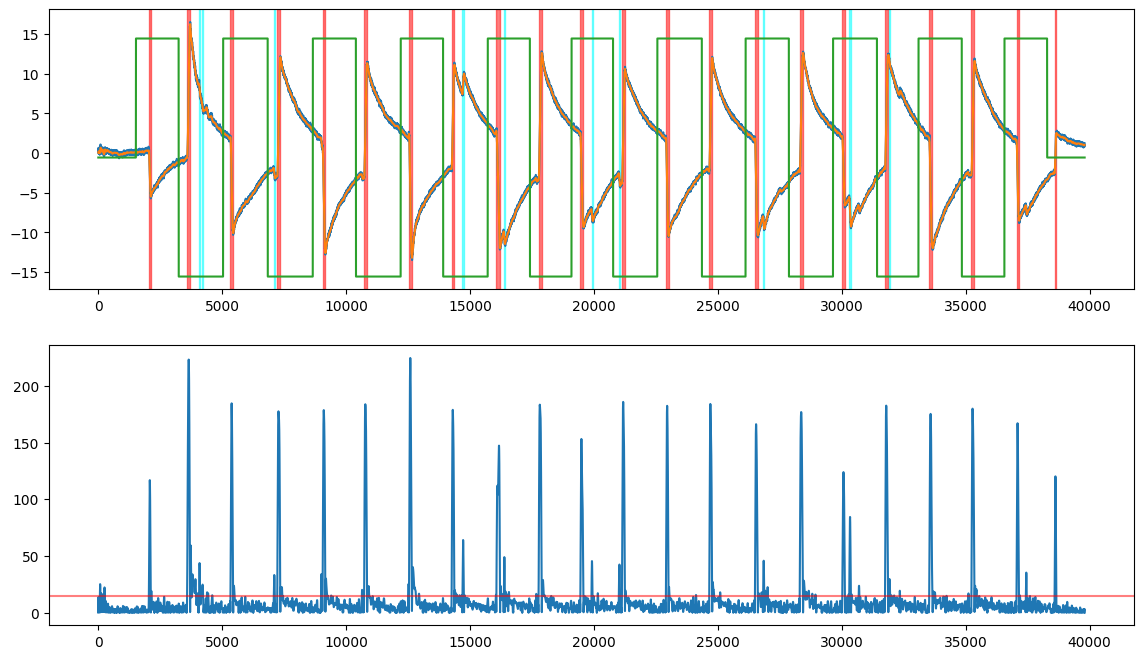

In [8]:
PLOT_START, PLOT_END = 0, time_channel[-1]
# PLOT_START, PLOT_END = 15000, 20000

plt.subplot(211)
plt.plot(time_channel[PLOT_START:PLOT_END], centered_hori_channel[PLOT_START:PLOT_END])
plt.plot(time_channel[PLOT_START:PLOT_END], denoised_hori_channel[PLOT_START:PLOT_END])
plt.plot(time_channel[PLOT_START:PLOT_END], centered_stim_channel[PLOT_START:PLOT_END])

filtered_impulses = []
for idx, (onset, offset, direction, size, duration, amplitude) in enumerate(filter_impulses(classified_impulses)):
    filtered_impulses.append((onset, offset, direction, size, duration, amplitude))
    
    if offset < PLOT_START:
        continue

    if onset > PLOT_END:
        continue
    
    if size == Size.Small:
        color = 'cyan'
    else:
        color = 'red'
    plt.axvspan(onset, offset, color=color, alpha=0.5)
    print(f"#{idx + 1:02} -", onset, offset, direction, size, duration, amplitude)
    
    

plt.subplot(212)
plt.plot(time_channel[PLOT_START:PLOT_END], abs_vel_channel[PLOT_START:PLOT_END])
plt.axhline(VELOCITY_THRESHOLD, color='red', alpha=0.5)

## Eliminando más movimientos inválidos

Lista de Eventos
1 - Size.Large - Movement.Antisaccade - 1517 - 2041 - 3242
2 - Size.Large - Movement.Antisaccade - 3242 - 3584 - 5035
2 - Size.Small - Movement.Saccade - 3242 - 4066 - 5035
2 - Size.Small - Movement.Saccade - 3242 - 4179 - 5035
3 - Size.Large - Movement.Antisaccade - 5035 - 5334 - 6835
4 - Size.Small - Movement.Saccade - 6835 - 7081 - 8654
4 - Size.Large - Movement.Antisaccade - 6835 - 7222 - 8654
5 - Size.Large - Movement.Antisaccade - 8654 - 9050 - 10394
6 - Size.Large - Movement.Antisaccade - 10394 - 10726 - 12200
7 - Size.Large - Movement.Antisaccade - 12200 - 12538 - 13912
8 - Size.Large - Movement.Antisaccade - 13912 - 14257 - 15712
8 - Size.Small - Movement.Antisaccade - 13912 - 14694 - 15712
9 - Size.Large - Movement.Antisaccade - 15712 - 16064 - 17414
9 - Size.Small - Movement.Antisaccade - 15712 - 16363 - 17414
10 - Size.Large - Movement.Antisaccade - 17414 - 17765 - 19093
11 - Size.Large - Movement.Antisaccade - 19093 - 19452 - 20770
11 - Size.Small - Moveme

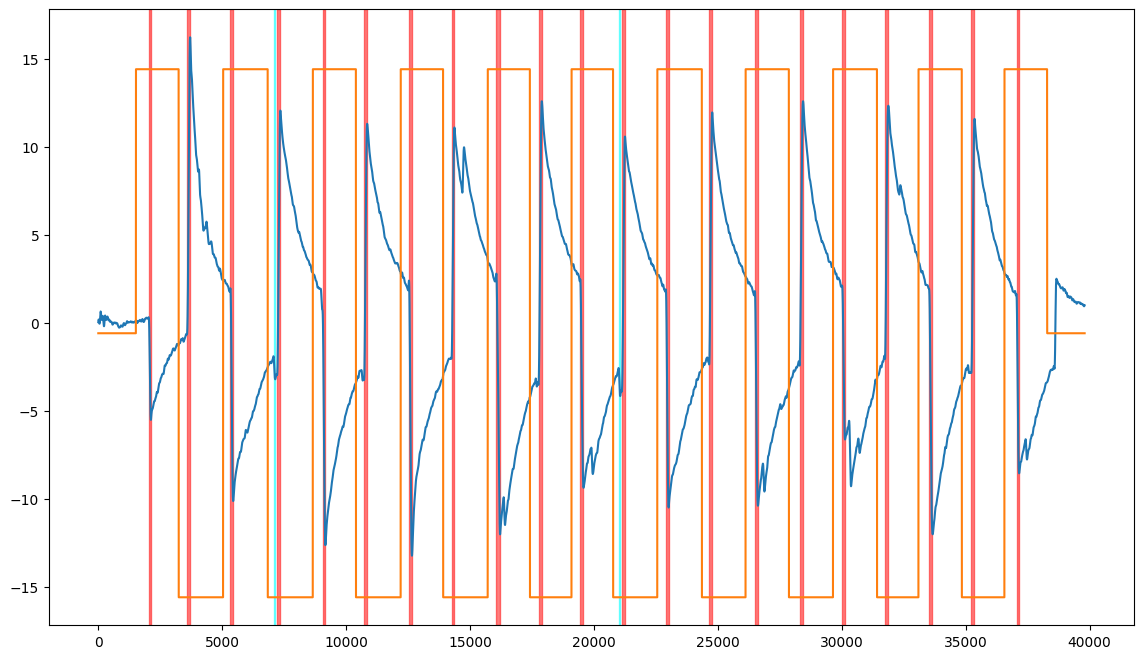

In [9]:
from dataclasses import dataclass
from enum import Enum

class StimuliTransitions:

    def __init__(self, stimuli: np.ndarray):
        self.transitions = []
        for idx in range(1, len(stimuli)):
            if stimuli[idx - 1] != stimuli[idx]:
                before_value = stimuli[idx - 1]
                after_value = stimuli[idx]

                if before_value < after_value:
                    self.transitions.append((idx, Direction.Left))
                else:
                    self.transitions.append((idx, Direction.Right))

    def __len__(self) -> int:
        return len(self.transitions)

    def __getitem__(self, pos: int) -> tuple[int, int, int, direction]:
        if self.transitions:
            idx = 0
            change, direction = self.transitions[idx]
            change_before = change
            while pos > change and idx < len(self.transitions) - 1:
                change_before = change
                idx += 1
                change, direction = self.transitions[idx]
            return idx, change, change_before, direction

        return 0, 0, Direction.Same


class Movement(Enum):
    Saccade = "saccade"
    Antisaccade = "antisaccade"
        

@dataclass
class Event:
    onset: int
    offset: int
    direction: Direction
    size: Size
    duration: int
    amplitude: float
    transition_index: int
    transition_change_index: int
    transition_change_before_index: int
    transition_direction: Direction
    movement: Movement

    def __str__(self):
        return f"{self.transition_index} - {self.size} - {self.movement} - {self.transition_change_before_index} - {self.onset} - {self.transition_change_index}"
    
transitions = StimuliTransitions(centered_stim_channel)

# Creando los eventos
event_list = []
for onset, offset, direction, size, duration, amplitude in filtered_impulses:
    t_idx, t_change, t_change_before, t_direction = transitions[onset]

    if direction == t_direction:
        movement = Movement.Saccade
    else:
        movement = Movement.Antisaccade
    
    event = Event(
        onset=onset,
        offset=offset,
        direction=direction,
        size=size,
        duration=duration,
        amplitude=amplitude,
        transition_index=t_idx,
        transition_change_index=t_change,
        transition_change_before_index=t_change_before,
        transition_direction=t_direction,
        movement=movement,
    )

    event_list.append(event)

print("Lista de Eventos")
for event in event_list:
    print(event)
print()
print()

def filter_events(events: list[Event]) -> Iterator[Event]:
    for idx, event in enumerate(events):
        if event.size == Size.Large and event.movement == Movement.Antisaccade:
            # Es una antisácada válida por lo que la lanzamos
            yield event
            continue

        if event.size == Size.Small and event.movement == Movement.Saccade:
            if idx == len(events) - 1:
                # Es el último evento por lo tanto nos la saltamos
                continue

            next_event = events[idx + 1]
            if event.transition_index != next_event.transition_index:
                # El evento y el siguiente no están en la misma transición de estímulo por lo que nos la saltamos
                continue

            if next_event.size == Size.Large and next_event.movement == Movement.Antisaccade:
                # El siguiente evento es una antisácada correcta
                # Por lo que hace que el movimiento sea un movimiento correctivo correcto
                # Por lo tanto se lanza también
                yield event

PLOT_START, PLOT_END = 0, time_channel[-1]
#PLOT_START, PLOT_END = 1500, 3300

plt.plot(time_channel[PLOT_START:PLOT_END], denoised_hori_channel[PLOT_START:PLOT_END])
plt.plot(time_channel[PLOT_START:PLOT_END], centered_stim_channel[PLOT_START:PLOT_END])

filtered_events = [event for event in filter_events(event_list)]
print("Lista de Eventos Filtrados")
for event in filtered_events:
    if event.offset < PLOT_START:
        continue

    if event.onset > PLOT_END:
        continue
    
    if event.movement == Movement.Saccade:
        color = 'cyan'
    else:
        color = 'red'
        
    plt.axvspan(event.onset, event.offset, color=color, alpha=0.5)
    print(event)

# Biomarcadores antisacádicos

In [10]:
SAMPLES_INTERVAL = 1/1000
def antisaccade_latencies_biomarker(events: Iterator[Event]) -> list[float]:
    latencies = []
    for event in events:
        if event.movement == Movement.Antisaccade:
            latency = (event.onset - event.transition_change_before_index) * SAMPLES_INTERVAL
            latencies.append(latency)
    return latencies

In [41]:
latencias = antisaccade_latencies_biomarker(filtered_events)
print(latencias)
print(len(latencias))

[0.524, 0.342, 0.299, 0.387, 0.396, 0.332, 0.338, 0.34500000000000003, 0.352, 0.35100000000000003, 0.359, 0.359, 0.34900000000000003, 0.3, 0.38, 0.439, 0.376, 0.326, 0.434, 0.39, 0.489]
21


In [42]:
# RATE -> Biomarcador agregado
def antisaccade_response_inhibition_biomarker(events: Iterator[Event]) -> float:
    num_saccades_movements = 0
    num_antisaccades_movements = 0
    for event in events:
        if event.movement == Movement.Antisaccade:
            num_antisaccades_movements += 1
        if event.movement == Movement.Saccade:
            num_saccades_movements += 1
    return num_saccades_movements/num_antisaccades_movements

In [39]:
inhibition_biomarker = antisaccade_response_inhibition_biomarker(filtered_events)
print(inhibition_biomarker)


0.09523809523809523


Para el siguiente -> problema en la calibrión o escalar.

In [49]:
def antisaccade_location_memory_biomarker(channel: np.ndarray, stimuli: np.ndarray, events: Iterator[Event]) -> list[float]:
    accuracy_locations_memory = []
    amplitude_stimuli = abs(min(stimuli) - max(stimuli))/2  
    for event in events:
        if event.movement == Movement.Antisaccade:
            amplitude_channel = max(abs(max(channel[event.onset:event.offset])), abs(min(channel[event.onset:event.offset]))) - min(abs(max(channel[event.onset:event.offset])), abs(min(channel[event.onset:event.offset])))
            location_memory = abs(amplitude_stimuli - amplitude_channel)/amplitude_stimuli
            print(amplitude_stimuli, amplitude_channel)
            accuracy_locations_memory.append(location_memory)
    return accuracy_locations_memory

In [50]:
locations = antisaccade_location_memory_biomarker(denoised_hori_channel, centered_stim_channel, filtered_events)
print(locations)
print(len(locations))

15.0 5.174842501473436
15.0 15.618056433960847
15.0 8.107295672114338
15.0 9.14114530488028
15.0 11.858401981970323
15.0 8.064551170120149
15.0 10.762574632284837
15.0 9.093591975178493
15.0 9.160985592211366
15.0 9.083924022665581
15.0 6.831091918156483
15.0 6.706264399374467
15.0 8.54501848239659
15.0 9.621851552373998
15.0 8.512621538684023
15.0 10.163114322687067
15.0 4.472047357512599
15.0 10.258607709995161
15.0 10.000327287574658
15.0 8.774739856206924
15.0 6.851224720937032
[0.655010499901771, 0.04120376226405646, 0.45951362185904415, 0.39059031300798125, 0.20943986786864516, 0.4623632553253234, 0.2824950245143442, 0.3937605349881005, 0.3892676271859089, 0.39440506515562795, 0.5445938721229011, 0.5529157067083689, 0.43033210117356074, 0.3585432298417334, 0.43249189742106514, 0.32245904515419554, 0.7018635094991601, 0.31609281933365596, 0.33331151416168947, 0.4150173429195384, 0.5432516852708644]
21


In [36]:
# Se podría sacar el calculo de la velocidad fuera del método
def antisaccade_velocities_biomarker(channel: np.ndarray, events: Iterator[Event]) -> list[float]:
    velocities = []
    for event in events:
        if event.movement == Movement.Antisaccade:
            velocidad_max = max(abs(differentiate(channel[event.onset:event.offset])))
            velocities.append(velocidad_max)
    return velocities

In [37]:
velocities = antisaccade_velocities_biomarker(denoised_hori_channel, filtered_events)
print(velocities)
print(len(velocities))

[116.8613776987401, 223.31492814839464, 184.6754230358352, 177.64512158396326, 178.7202476348639, 183.89473863185538, 224.7147009377704, 178.945766889295, 147.3239589182979, 183.53022477812328, 153.21668043352435, 185.9596806562755, 182.4801257178086, 184.1189701459594, 166.2652272105308, 176.9747912291547, 123.96317210362216, 182.67635213396971, 175.38580800653733, 179.97881137449735, 167.08869247079963]
21


In [17]:
SAMPLES_INTERVAL = 1/1000
def antisaccade_durations_biomarker(events: Iterator[Event]) -> list[float]:
    durations = []
    for event in events:
        if event.movement == Movement.Antisaccade:
            duration = (event.offset - event.onset) * SAMPLES_INTERVAL
            durations.append(duration)
    return durations

In [28]:
durations = antisaccade_durations_biomarker(filtered_events)
print(durations)
print(len(durations))

[0.075, 0.11800000000000001, 0.10300000000000001, 0.11800000000000001, 0.109, 0.116, 0.112, 0.107, 0.14300000000000002, 0.124, 0.11900000000000001, 0.116, 0.10400000000000001, 0.114, 0.111, 0.126, 0.10200000000000001, 0.122, 0.128, 0.12, 0.098]
21


In [33]:
SAMPLES_INTERVAL = 1/1000
def antisaccade_correction_latencies_biomarker(events: Iterator[Event]) -> list[float]:
    #Se crea una lista porque se necesita un valor del evento anterior
    def create_list_event(events: Iterator[Event]):
        list = []
        for event in events:
            list.append(event)
        return list
           
    correction_latencies = []
    for idx, event in enumerate(create_list_event(events)):
        if events[idx-1].movement == Movement.Saccade and event.movement == Movement.Antisaccade and event.transition_index == events[idx-1].transition_index:
            correction_latency = (events[idx].onset - events[idx-1].offset) * SAMPLES_INTERVAL
            correction_latencies.append(correction_latency)
            saccade_has_ocurred = False
        elif events[idx-1].movement != Movement.Saccade and event.movement == Movement.Antisaccade:
            correction_latencies.append(0)
    return correction_latencies

In [34]:
latencias_correctoras = antisaccade_correction_latencies_biomarker(filtered_events)
print(latencias_correctoras)
print(len(latencias_correctoras))

[0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.081, 0, 0, 0, 0, 0, 0, 0, 0, 0]
21


# Haciendo antisaccades.py

In [ ]:
class Direction(Enum):
    Same = "same"
    Left = "left"
    Right = "right"

class Size(Enum):
    Invalid = "inv"
    Small = "small"
    Large = "large"

class Movement(Enum):
    Saccade = "saccade"
    Antisaccade = "antisaccade"

@dataclass
class Event:
    onset: int
    offset: int
    direction: Direction
    size: Size
    duration: int
    amplitude: float
    transition_index: int
    transition_change_index: int
    transition_direction: Direction
    movement: Movement

    def __str__(self):
        return f"{self.transition_index} - {self.size} - {self.movement}"

@dataclass
class AntissaccadeBiomarkers:
    latency: float
    location_memory: float
    peak_velocity: float
    duration: float
    correction_latency: float

@dataclass
class AntissaccadicBiomarkers:
    antisaccades: list[AntissaccadeBiomarkers]
    latency_mean: float
    latency_std: float
    location_memory_mean: float
    location_memory_std: float
    peak_velocity_mean: float
    peak_velocity_std: float
    duration_mean: float
    duration_std: float
    correction_latency_mean: float
    correction_latency_std: float
    response_inhibition: float



def antissacadic_biomarkers(channel: np.ndarray, stimuli: np.ndarray) -> AntissaccadicBiomarkers:
    antisaccades_movements = antisaccades(channel, stimuli)
    saccades_movements = saccades(channel, stimuli, antisaccades_movements)

    latencies = antisaccade_latencies_biomarker(stimuli, antisaccades_movements)
    inhibition = antisaccade_response_inhibition_biomarker(saccades_movements, antisaccades_movements)
    location_memory = antisaccade_location_memory_biomarker(channel, stimuli, antisaccades_movements)
    velocities = antisaccade_velocities_biomarker(channel, antisaccades_movements)
    durations = antisaccade_durations_biomarker(antisaccades_movements)
    correction_latencies = antisaccade_correction_latencies_biomarker(saccades_movements, antisaccades_movements)

    pas